In [1]:
# Data loading code provided by https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

path = '../data/PTBXL/'
sampling_rate=100

In [2]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

print(Y)

        patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
1          15709.0   56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0   19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0   37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0   24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0   19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...    ...  ...     ...     ...    ...   ...         ...   
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_d

In [3]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

  0%|          | 0/21799 [00:00<?, ?it/s]

100%|██████████| 21799/21799 [07:14<00:00, 50.18it/s]


In [4]:
print(np.mean(X,axis=(0,1)))
print(np.std(X,axis=(0,1)))
print(np.min(X,axis=(0,1)))
print(np.max(X,axis=(0,1)))

[-0.00159372 -0.00130339  0.00029046  0.00142973 -0.00089129 -0.00048323
  0.00017235 -0.00091383 -0.00148901 -0.00174604 -0.00076757 -0.00207504]
[0.15963173 0.16470071 0.16700576 0.13905983 0.14108336 0.14528336
 0.23367245 0.33765482 0.3336523  0.30584461 0.27314835 0.27562001]
[ -7.455  -5.856  -4.656  -3.679  -7.473  -5.3   -17.825 -11.102 -16.32
 -11.198 -13.055 -20.032]
[ 4.398  5.576  7.491  5.92   4.425  5.553 10.547 12.157  8.505  8.696
 17.212 12.966]


In [5]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print(agg_df)

                                               description  diagnostic  form  \
NDT                         non-diagnostic T abnormalities         1.0   1.0   
NST_                               non-specific ST changes         1.0   1.0   
DIG                                       digitalis-effect         1.0   1.0   
LNGQT                                     long QT-interval         1.0   1.0   
NORM                                            normal ECG         1.0   NaN   
IMI                         inferior myocardial infarction         1.0   NaN   
ASMI                    anteroseptal myocardial infarction         1.0   NaN   
LVH                           left ventricular hypertrophy         1.0   NaN   
LAFB                        left anterior fascicular block         1.0   NaN   
ISC_                                 non-specific ischemic         1.0   NaN   
IRBBB                 incomplete right bundle branch block         1.0   NaN   
1AVB                                 fir

In [6]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
print(Y['diagnostic_superclass'])

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21799, dtype: object


In [7]:
norm_count = 0
anom_classes = []
indiv_classes = []
for cls in Y['diagnostic_superclass']:
    if len(cls)==0:
        continue
    if cls == ['NORM']:
        norm_count += 1
    if cls not in anom_classes:
        anom_classes.append(cls)
    for indiv_cls in cls:
        if indiv_cls not in indiv_classes:
            indiv_classes.append(indiv_cls)
print(norm_count)
print(norm_count/21799)
print(anom_classes)
print(indiv_classes)

9069
0.4160282581769806
[['NORM'], ['MI'], ['STTC'], ['HYP'], ['CD'], ['MI', 'STTC'], ['HYP', 'CD'], ['MI', 'CD'], ['CD', 'STTC'], ['MI', 'HYP'], ['MI', 'STTC', 'HYP'], ['MI', 'CD', 'STTC', 'HYP'], ['HYP', 'STTC'], ['NORM', 'CD'], ['MI', 'CD', 'STTC'], ['HYP', 'CD', 'STTC'], ['NORM', 'STTC'], ['MI', 'CD', 'HYP'], ['NORM', 'CD', 'STTC'], ['HYP', 'CD', 'STTC', 'MI'], ['NORM', 'CD', 'HYP'], ['NORM', 'HYP'], ['HYP', 'CD', 'MI'], ['HYP', 'STTC', 'MI'], ['HYP', 'MI'], ['HYP', 'MI', 'STTC'], ['NORM', 'CD', 'MI', 'HYP'], ['HYP', 'CD', 'MI', 'STTC']]
['NORM', 'MI', 'STTC', 'HYP', 'CD']


In [8]:
def get_anomaly_labels(y_dic):
    tmp = []
    zero_count = 0
    for diag in y_dic["diagnostic_superclass"]:
        if len(diag) == 0:
            zero_count += 1
            tmp.append(1)
            continue
        if diag == ['NORM']:
            tmp.append(0)
        else:
            tmp.append(1)
    y_dic['anomaly_labels'] = tmp
    print("Number of unclassified ECGs: ", zero_count)
    return y_dic

# Get anomaly labels

Y = get_anomaly_labels(Y)
print(Y['anomaly_labels'])

print(Y['anomaly_labels'][1])
norm_count = 0
for lbl in Y['anomaly_labels']:
    if lbl==0:
        norm_count += 1
print(norm_count)
print(norm_count/21799)

Number of unclassified ECGs:  411
ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21833    1
21834    0
21835    1
21836    0
21837    0
Name: anomaly_labels, Length: 21799, dtype: int64
0
9069
0.4160282581769806


In [9]:
def get_anomaly_cls_labels(y_dic):
    tmp = []
    zero_count = 0
    mi_count = 0
    sttc_count = 0
    hyp_count = 0
    cd_count = 0
    for diag in y_dic["diagnostic_superclass"]:
        if len(diag) == 0:
            zero_count += 1
            tmp.append(5)
            continue
        if diag == ['NORM']:
            tmp.append(0)
        elif diag == ['MI']:
            tmp.append(1)
            mi_count += 1
        elif diag == ['STTC']:
            tmp.append(2)
            sttc_count += 1
        elif diag == ['HYP']:
            tmp.append(3)
            hyp_count += 1
        elif diag == ['CD']:   
            tmp.append(4)
            cd_count += 1
        else:
            tmp.append(5)
    y_dic['anomaly_cls_labels'] = tmp
    print("Number of unclassified ECGs: ", zero_count)
    return y_dic, mi_count, sttc_count, hyp_count, cd_count

# Get anomaly labels

Y, mi, sttc, hyp, cd = get_anomaly_cls_labels(Y)
print(Y['anomaly_cls_labels'])
print(Y['anomaly_cls_labels'][1])
norm_count = 0
for lbl in Y['anomaly_cls_labels']:
    if lbl==0:
        norm_count += 1
print(norm_count)
print(norm_count/21799)
print("MI count: ", mi)
print("STTC count: ", sttc)
print("HYP count: ", hyp)
print("CD count: ", cd)

Number of unclassified ECGs:  411
ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21833    2
21834    0
21835    2
21836    0
21837    0
Name: anomaly_cls_labels, Length: 21799, dtype: int64
0
9069
0.4160282581769806
MI count:  2532
STTC count:  2400
HYP count:  535
CD count:  1708


In [27]:
# Normalize data per sensor 3 (normalize every clip to itself)
from sklearn.preprocessing import MinMaxScaler

print(X.shape)
X_reshaped = np.transpose(X, (0,2,1))
print(X_reshaped.shape)
X_reshaped = np.reshape(X_reshaped, (-1, X_reshaped.shape[-1]))
print(X_reshaped.shape)
normalizer = MinMaxScaler(feature_range=(0, 1))
X_norm = []
for i in tqdm(range(X_reshaped.shape[0])):
    X_norm.append(np.transpose(normalizer.fit_transform(np.expand_dims(X_reshaped[i,:], axis=1))))
print(X_norm[0].shape)
X_norm = np.concatenate(X_norm, axis=0)
print(X_norm.shape)

X_norm_reshaped = np.reshape(X_norm, (-1, 12, 1000))
print(X_norm_reshaped.shape)
X_norm_reshaped = np.transpose(X_norm_reshaped, (0,2,1))
print(X_norm_reshaped.shape)
print(normalizer.data_min_)
print(normalizer.data_max_)
print(normalizer.data_range_)
print(np.min(X_norm))
print(np.max(X_norm))
print(X_reshaped.shape)
print((X == np.transpose(X_reshaped.reshape((-1, 12, 1000)), (0,2,1))).all())
X_norm = X_norm_reshaped

(21799, 1000, 12)
(21799, 12, 1000)
(261588, 1000)


100%|██████████| 261588/261588 [00:33<00:00, 7724.31it/s]


(1, 1000)
(261588, 1000)


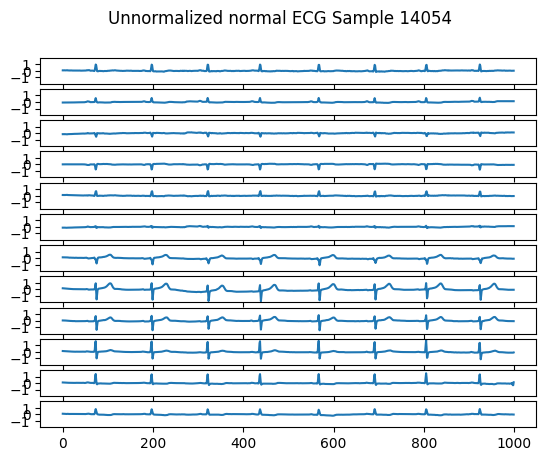

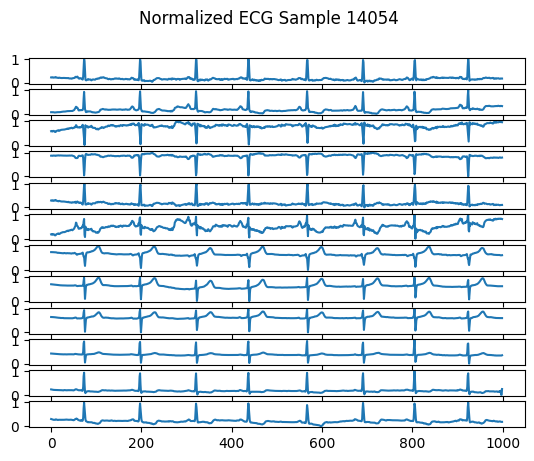

In [14]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, 21799)

if Y['anomaly_labels'][idx+1] == 0:
    label = 'normal'
elif Y['anomaly_labels'][idx+1] == 1:
    label = 'abnormal'

fig, axs = plt.subplots(12, sharex=True, sharey=True)
fig.suptitle('Unnormalized {} ECG Sample {}'.format(label, idx))
for i in range(12):
    axs[i].plot(X[idx,:,i])
plt.show()

fig, axs = plt.subplots(12, sharex=True, sharey=True)
fig.suptitle('Normalized ECG Sample {}'.format(idx))
for i in range(12):
    axs[i].plot(X_norm[idx,:,i])
plt.show()



In [29]:
# Split data into train and test
test_fold = 10
# Train
X_train_norm = X_norm[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].anomaly_labels
# Test
X_test_norm = X_norm[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].anomaly_labels

In [30]:
for lbl in Y['anomaly_cls_labels']:
    if lbl==0:
        norm_count += 1

In [31]:
print(X_train_norm.shape)
print(y_train.shape)
print(X_test_norm.shape)
print(y_test.shape)
print(sum(y_train))
print(sum(y_test))

(19601, 1000, 12)
(19601,)
(2198, 1000, 12)
(2198,)
11444
1286


In [67]:
# Select abnormal classes to include in training (general vs hard setting)
import os
import h5py

# inc_cls = ['MI', 'STTC', 'HYP', 'CD']
inc_cls = ['HYP']
suffix = 'hyp'
num_shots = 30
# output_file_train = os.path.join(path,'ptbxl_train_{}.h5'.format(suffix))
output_file_train = os.path.join(path,'ptbxl_train_{}{}.h5'.format(suffix,num_shots))
# output_file_test = os.path.join(path,'ptbxl_train.h5'.format(suffix))

cls_labels = Y[(Y.strat_fold != test_fold)].anomaly_cls_labels
mi_idx = np.where(cls_labels == 1)[0]
sttc_idx = np.where(cls_labels == 2)[0]
hyp_idx = np.where(cls_labels == 3)[0]
cd_idx = np.where(cls_labels == 4)[0]
norm_idx = np.where(cls_labels == 0)[0]

class_idx = {'MI': 1, 'STTC': 2, 'HYP': 3, 'CD': 4}
normal_seen_labels = []
normal_count = 0
for lbl in cls_labels:
    if lbl == 0:
        normal_seen_labels.append(1)
    elif lbl == class_idx[inc_cls[0]]:
        normal_seen_labels.append(1)
    else:
        normal_seen_labels.append(0)
    if lbl == 0:
        normal_count += 1

normal_seen_labels = np.array(normal_seen_labels)

X_anom = []
if 'MI' in inc_cls:
    X_anom.append(X_train_norm[mi_idx[:num_shots]])
if 'STTC' in inc_cls:
    X_anom.append(X_train_norm[sttc_idx[:num_shots]])
if 'HYP' in inc_cls:
    X_anom.append(X_train_norm[hyp_idx[:num_shots]])
if 'CD' in inc_cls:
    X_anom.append(X_train_norm[cd_idx[:num_shots]])
X_anom = np.concatenate(X_anom, axis=0)


with h5py.File(output_file_train, 'w') as hdf:
    hdf.create_dataset('X', data=X_train_norm)
    hdf.create_dataset('y', data=y_train)
    hdf.create_dataset('X_anom', data=X_anom)
    hdf.create_dataset('normal_seen_labels', data=normal_seen_labels)

# with h5py.File(output_file_test, 'w') as hdf:
#     hdf.create_dataset('X', data=X_test_norm)
#     hdf.create_dataset('y', data=y_test)

# norm = X_train_norm[norm_idx[:num_shots]]
# idx = 6
# fig, axs = plt.subplots(5, sharex=True, sharey=True)
# for i in range(5):
#     # axs[i].plot(X_anom[idx,:,i],color='k')
#     axs[i].plot(norm[idx,:,i],color='k')
#     axs[i].set_xticklabels([])
#     axs[i].set_yticklabels([])
# # plt.savefig("normal.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0.0)
# plt.show()

(19601, 1000, 12)
(19601,)
(30, 1000, 12)
(19601,)
11444
8157


Class Norm count:  (912,)
Class MI count:  (256,)
Class STTC count:  (242,)
Class HYP count:  (56,)
Class CD count:  (184,)
Class multiple/unclassified count:  (548,)
Class total count:  (2198,)
[0 0 0 ... 0 1 2]
2198
912
184
1102


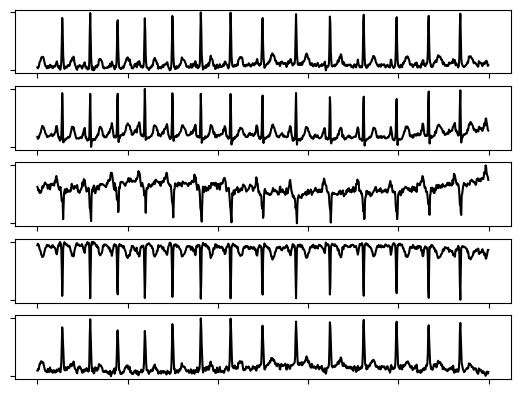

In [18]:
import matplotlib.pyplot as plt

cls_labels_test = Y[(Y.strat_fold == test_fold)].anomaly_cls_labels
print("Class Norm count: ", np.where(cls_labels_test == 0)[0].shape)
print("Class MI count: ", np.where(cls_labels_test == 1)[0].shape)
print("Class STTC count: ", np.where(cls_labels_test == 2)[0].shape)
print("Class HYP count: ", np.where(cls_labels_test == 3)[0].shape)
print("Class CD count: ", np.where(cls_labels_test == 4)[0].shape)
print("Class multiple/unclassified count: ", np.where(cls_labels_test == 5)[0].shape)
print("Class total count: ", cls_labels_test.shape)

seen_class = "cd"
class_idx = {'mi': 1, 'sttc': 2, 'hyp': 3, 'cd': 4}
seen_unseen_labels = []
for lbl in cls_labels_test:
    if lbl == 0:
        seen_unseen_labels.append(0)
    elif lbl == class_idx[seen_class]:
        seen_unseen_labels.append(1)
    else:
        seen_unseen_labels.append(2)

seen_unseen_labels = np.array(seen_unseen_labels)
print(seen_unseen_labels)
print(len(seen_unseen_labels))
print(len(np.where(np.array(seen_unseen_labels) == 0)[0]))
print(len(np.where(np.array(seen_unseen_labels) == 1)[0]))
print(len(np.where(np.array(seen_unseen_labels) == 2)[0]))

output_file_test = os.path.join(path,'ptbxl_test_{}.h5'.format(seen_class))
with h5py.File(output_file_test, 'w') as hdf:
    hdf.create_dataset('X', data=X_test_norm)
    hdf.create_dataset('y', data=y_test)
    hdf.create_dataset('seen_unseen_labels', data=seen_unseen_labels)

# output_file_test = os.path.join(path,'ptbxl_test.h5'.format(seen_class))
# with h5py.File(output_file_test, 'w') as hdf:
#     hdf.create_dataset('X', data=X_test_norm)
#     hdf.create_dataset('y', data=y_test)
#     hdf.create_dataset('seen_unseen_labels', data=seen_unseen_labels)
#     hdf.create_dataset('cls_labels', data=cls_labels_test)